In [1]:
import pandas as pd
import numpy as np
import healpy as hp
import astropy
from astropy.coordinates import SkyCoord, search_around_sky
from astropy.io import fits
from scipy.optimize import least_squares
from tqdm.notebook import tqdm


import pysm3
import pysm3.units as u

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
rcParams['mathtext.rm'] = 'Times New Roman' 
rcParams['text.usetex'] = True
rcParams['font.family'] = 'times' #'sans-serif'

font_manager.findfont('serif', rebuild_if_missing=True)
fontsize = 14
rcParams.update({'font.size':fontsize})

from MyUnits import *

HomeDir = '../'
DataDir = HomeDir + 'data/'

### Useful functions

In [2]:
def remove_b(skymap, nside, b_min):
    skymap_cp = np.copy(skymap)
    lon, lat = hp.pix2ang(nside, np.arange(len(skymap_cp)), nest = False, lonlat = True)
    skymap_cp[np.abs(lat)<b_min] = np.nan
    
    return skymap_cp

Tcmb = 2.725 * Kelvin

def cmb_bt(freq):
    return freq/(np.exp(freq/(2.72548 * Kelvin))-1)

def planckcorr():
    return 

fng_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["black", "blue", "yellow","red"])

# Test map:  408 MHz (Haslam et al.)
rms Noise (K) : 1.2

Calibration error : 10\%

Zero-levek (K) : 3

In [3]:
file = DataDir + 'lambda_haslam408_dsds.fits'#'MAIPU_MU_1_64.fits' # #lambda_haslam408_nofilt.fits'#'haslam408_dsds_Remazeilles2014.fits' #
fits.info(file)

radio_map = fits.open(file)
radio_data = radio_map[1].data # assuming the first extension is a table
radio_data.shape #healpix number

Filename: ../data/lambda_haslam408_dsds.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   ()      
  1  Archive Map Table    1 BinTableHDU     33   3145728R x 2C   [E, E]   


(3145728,)

In [4]:
radio_data['TEMPERATURE'].shape

(3145728,)

In [5]:
radio_temps = radio_data['TEMPERATURE'].flatten() #radio_temps = radio_data['TEMPERATURE'].flatten() #weird format, need to flatten array

In [6]:
#radio_temps = radio_temps / 1000

In [7]:
#radio_temps[radio_temps < 0] = np.nan

In [8]:
radio_temps = hp.reorder(radio_temps, n2r = True)

In [9]:
radio_temps = radio_temps - cmb_bt(408 * MHz) / Kelvin; cmb_bt(408 * MHz) / Kelvin

2.7239223044616807

In [10]:
radio_temps_64 = hp.ud_grade(radio_temps, 64)

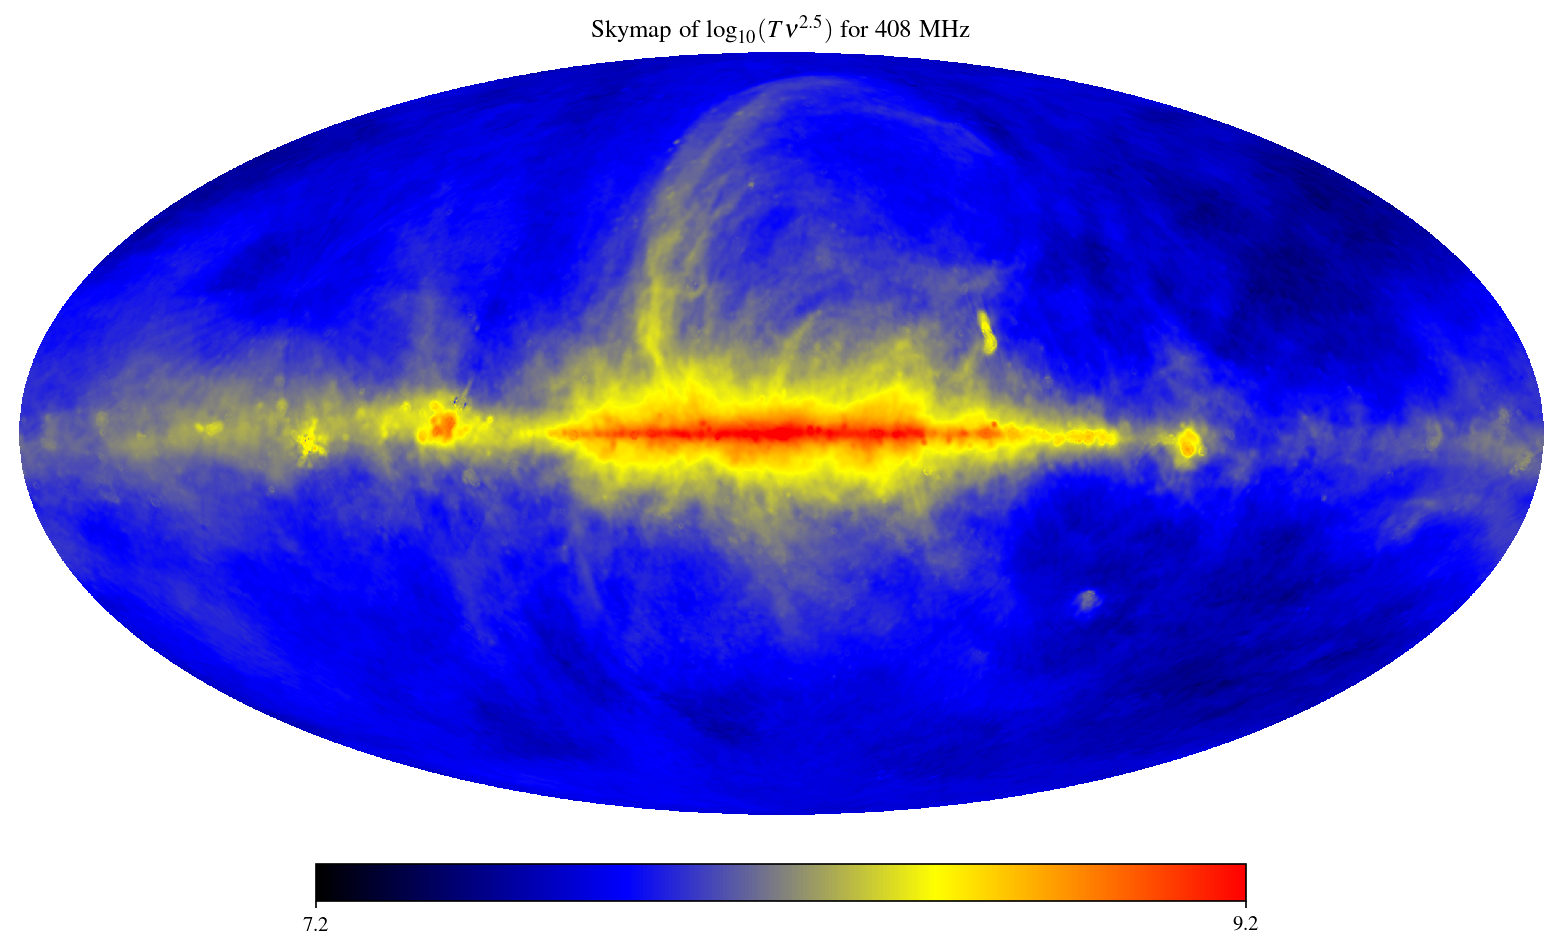

In [11]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(radio_temps * (408 ** 2.5))
hp.mollview(map, xsize = 4000, nest = False, hold = True, min = 7.2, max = 9.2, cmap = fng_cmap, title=r"Skymap of $\log_{10}(T \nu ^{2.5})$ for 408 MHz")
fig = plt.gcf()
ax = plt.gca()
#image = ax.get_images()[0]
#cbar = fig.colorbar(image, ax=ax,fraction=0.023);
#cbar.set_label(r'$\log_{10}(T \nu^{2.5})$')

In [12]:
len(radio_temps[np.isnan(radio_temps)])

0

In [13]:
#downgrade resolution to nside = 64

radio_temps_64 = hp.pixelfunc.ud_grade(radio_temps, 64, pess=False, order_in='RING', order_out='RING', power=None, dtype=None)

In [14]:
radio_temps_64
len(radio_temps_64)

49152

In [15]:
hp.npix2nside(len(radio_temps))

512

In [16]:
len(radio_temps_64)/12

4096.0

In [17]:
np.log2(4096)

12.0

In [18]:
radio_temps_c = hp.pixelfunc.ud_grade(radio_temps, 128, pess=False, order_in='RING', order_out='RING', power=None, dtype=None)

# Fluctuation map (parallelized)

- Most of diffuse Galactic synchrotron emission is induced by the random component of the GMF
- Random magnetic field introduces a variance in the intensity of radio maps
- Must average out fluctuations due to random magnetic field and compare data with that
- Can directly infer these fluctuations by looking at intensity variance in a given angular region, estimate how well synch model reproduces observations

In [79]:
'''
(1) Consider survey at original resolution
(2) Estimate temperature variance in region of 14.7 degrees
(3) This is \simga_i^B, then get the fluctuation by adding the experimental error in quadrature
'''

'\n(1) Consider survey at original resolution\n(2) Estimate temperature variance in region of 14.7 degrees\n(3) This is \\simga_i^B, then get the fluctuation by adding the experimental error in quadrature\n'

In [91]:
skymap = radio_temps_c

In [92]:
from joblib import Parallel, delayed

In [165]:
nside = hp.npix2nside(len(skymap))
pix_list = np.arange(len(skymap))
vectors = hp.pix2vec(nside, pix_list)

root_mean_sq = 1.2
calibration_err = 0.1

In [166]:
def fluct_map_par(idx, skymap, nside, vec, rms, calib):
    if (np.isnan(skymap[idx])):
        return np.nan
    else:
        inds = hp.query_disc(nside, (vec[0][idx], vec[1][idx], vec[2][idx]), radius = 7.35 * degree, inclusive = True)
        temps = skymap[inds]
        temps_r = temps[~np.isnan(temps)]
        
        f = np.sqrt(np.var(temps_r) + rms**2 + (calib * skymap[idx])**2)
        return f

In [167]:
num_cores_used = 1

f_map = Parallel(n_jobs=num_cores_used)(delayed(fluct_map_par)(idx, skymap, nside, vectors, root_mean_sq, calibration_err)
                                              for idx in tqdm(pix_list))

  0%|          | 0/196608 [00:00<?, ?it/s]

In [104]:
f_map_np = np.asarray(f_map)

In [105]:
np.save('./fluct_map_408.npy', f_map_np)

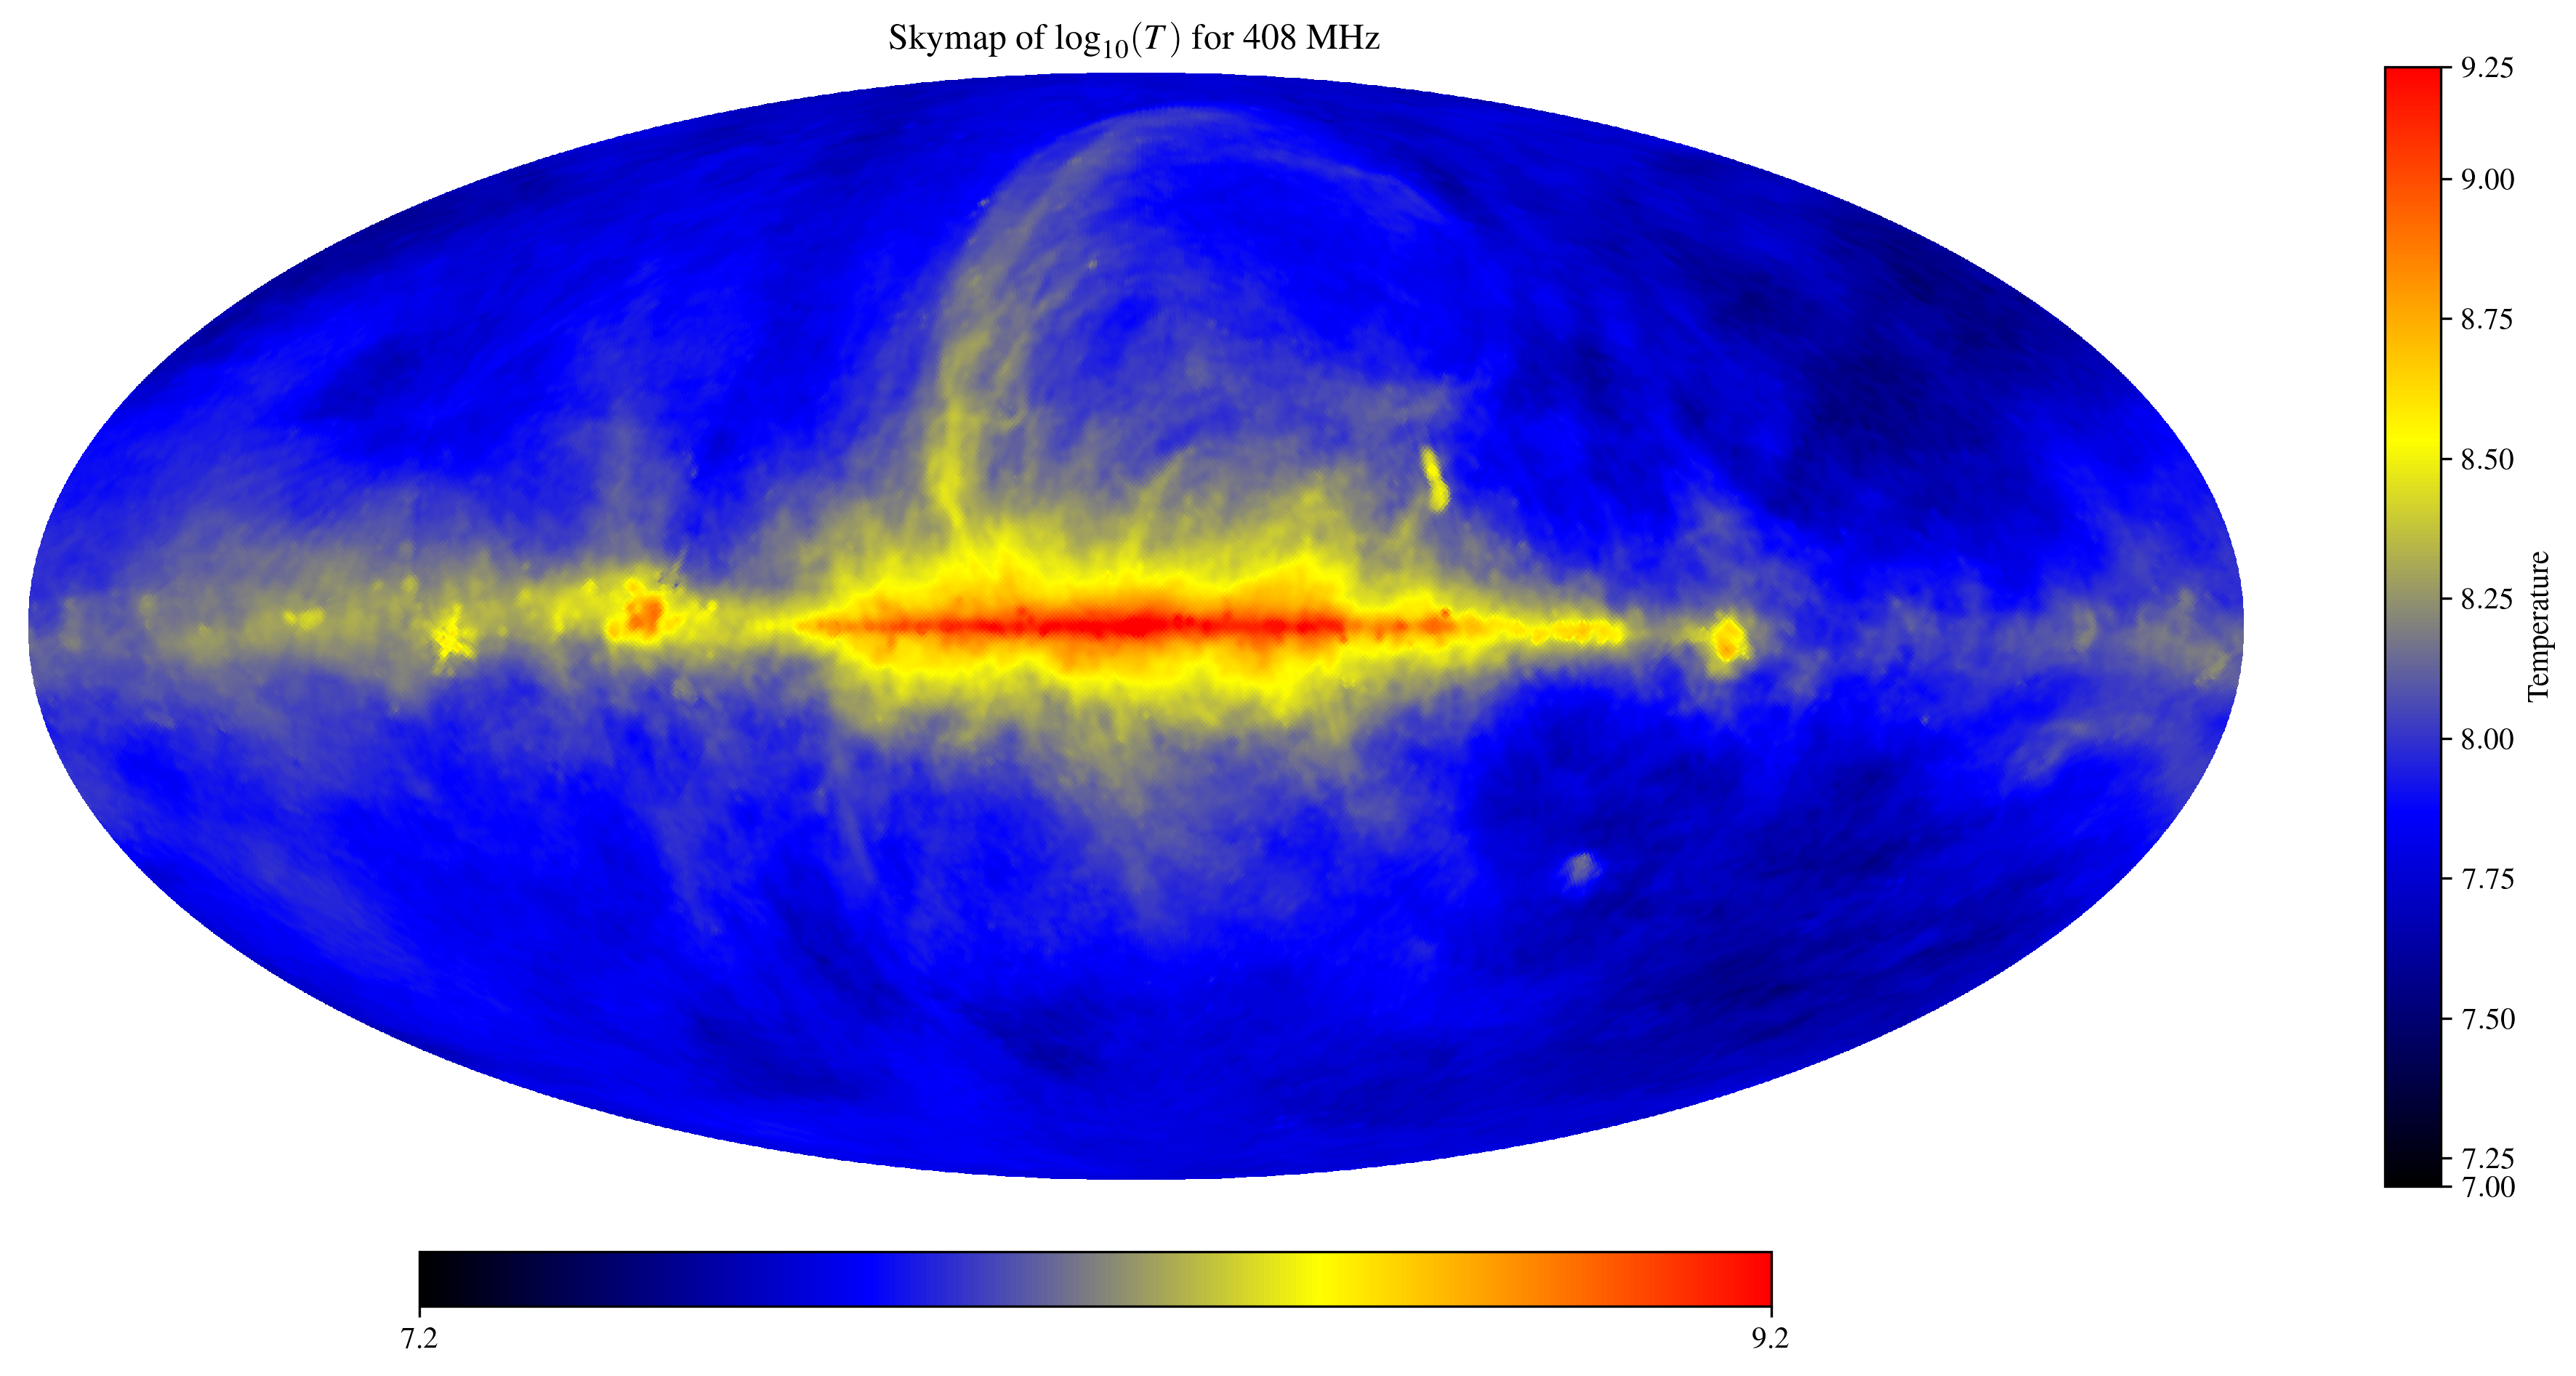

In [106]:
plt.subplots(1,1,figsize=(16,8),dpi = 300)
map = np.log10(skymap * (408**2.5))
hp.mollview(map, xsize = 4000, nest = False, hold = True, min = 7.2, max = 9.2, cmap = fng_cmap, title=r"Skymap of $\log_{10}(T)$ for 408 MHz")
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'Temperature')

In [107]:
print(len(skymap[np.isnan(skymap)])); print(len(skymap[skymap < 0]))

0
0


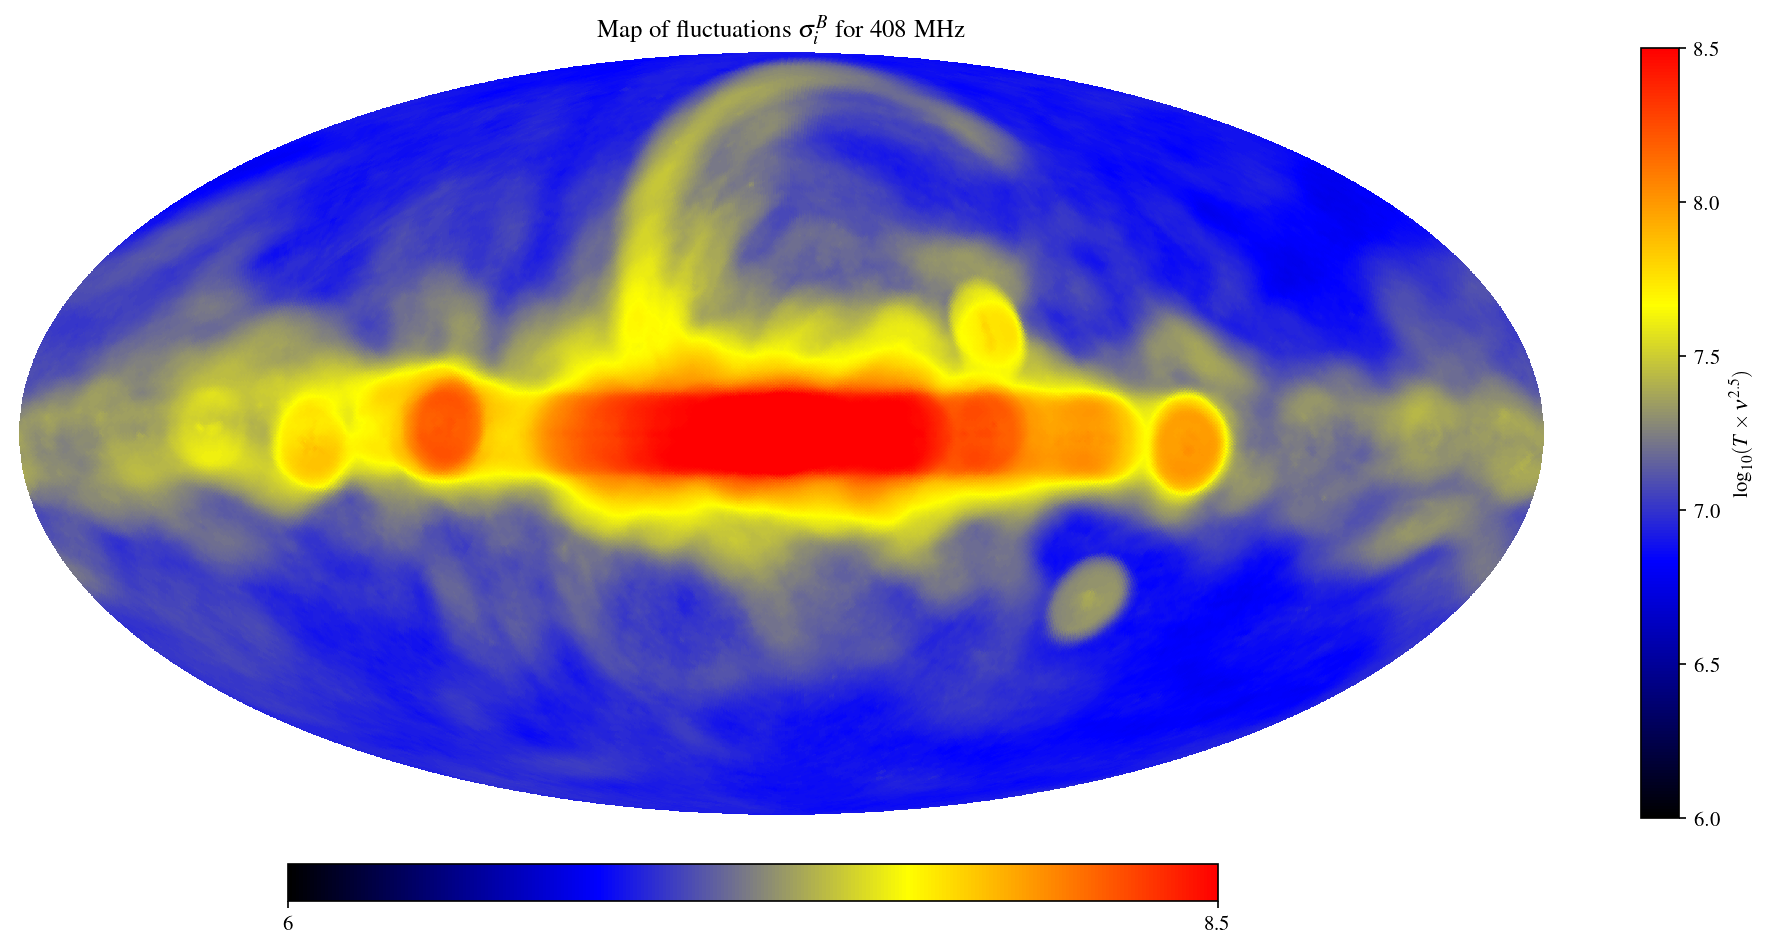

In [108]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(f_map_np * (408**2.5))
hp.mollview(map, xsize = 4000, nest = False, hold = True, cmap = fng_cmap, min = 6, max = 8.5, title=r"Map of fluctuations $\sigma_i^B$ for 408 MHz")
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T\times \nu^{2.5})$')

In [30]:
fluc_map_64 = hp.ud_grade(f_map_np, 64)

# GALPROP Map

In [31]:
#conversion factor 

conv_fac = 2 * np.pi**2 * (Meter**2 * Second * Joule)/(CentiMeter**2*Second*MeV); conv_fac

1.2320270115419999e+18

In [32]:
file = DataDir + 'synchrotron_healpix_54_0bf70005.gz'
#fits.info(file)

synch = fits.open(file)
synch_data = synch[1].data # assuming the first extension is a table

labels = synch[2].data # labels of data
units = labels.names[0]

synch_data.shape #healpix number

(49152,)

In [33]:
spectra = synch_data['Spectra']

sp1 = spectra[:,0]
lab1= labels[0][0]

galprop_temps = sp1*conv_fac
galprop_temps

array([17.55817428, 17.55817428, 17.55817428, ..., 17.55479489,
       17.55479489, 17.55479489])

In [34]:
#galprop_templ = hp.ud_grade(galprop_temps,4)

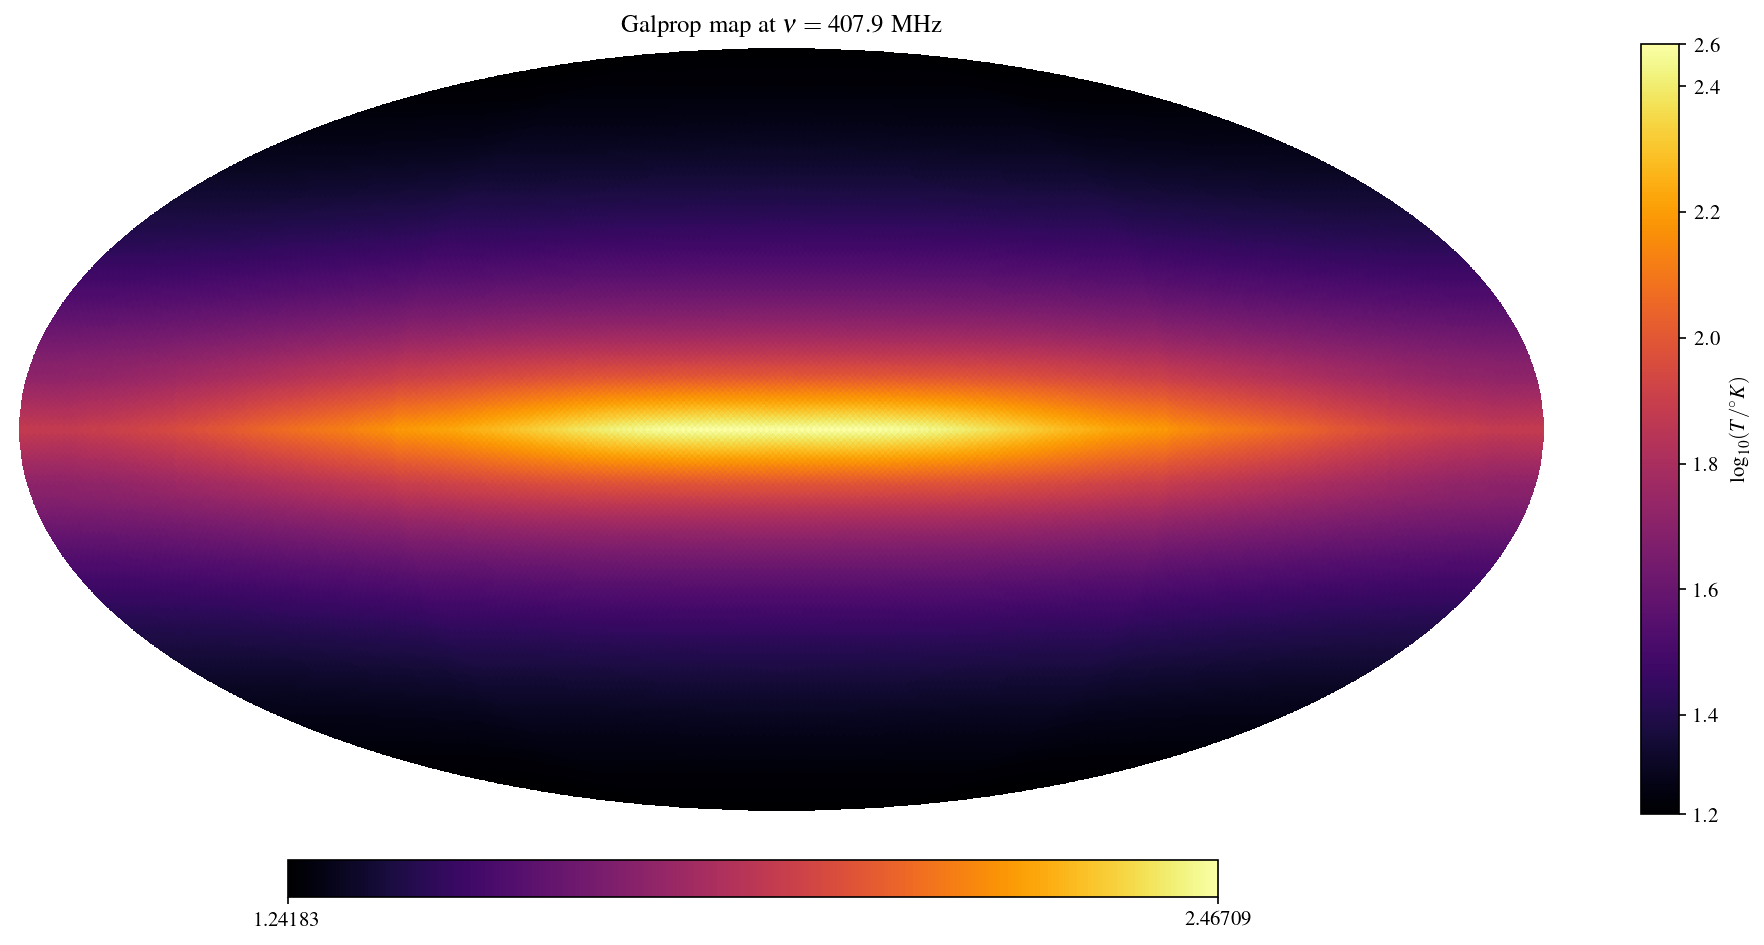

In [35]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(galprop_temps)
hp.mollview(map, xsize = 4000, nest = False, cmap = 'inferno', hold = True, title=r'Galprop map at $\nu=$ ' + str(lab1*Hz/MHz)[:5] + ' MHz')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

# Thermal Bremsstrahlung ([Finkbeiner 2003](https://arxiv.org/pdf/astro-ph/0301558.pdf))

In [36]:
file = DataDir + 'Halpha_fwhm06_1024.fits'
halpha = fits.open(file)
halpha_data = halpha[1].data

halpha_temps = halpha_data['TEMPERATURE']
halpha_temps

array([ 3.5607371,  3.4532976,  3.5398698, ..., 60.539658 , 41.669373 ,
       44.806786 ], dtype=float32)

In [37]:
#downgrade resolution to Nside = 64
halpha_temps_64 = hp.pixelfunc.ud_grade(halpha_temps, 64, pess=False, order_in='NEST', order_out='NEST', power=None, dtype=None)

#re-order map from nested to ring
halpha_temps_64 = hp.reorder(halpha_temps_64, n2r=True)

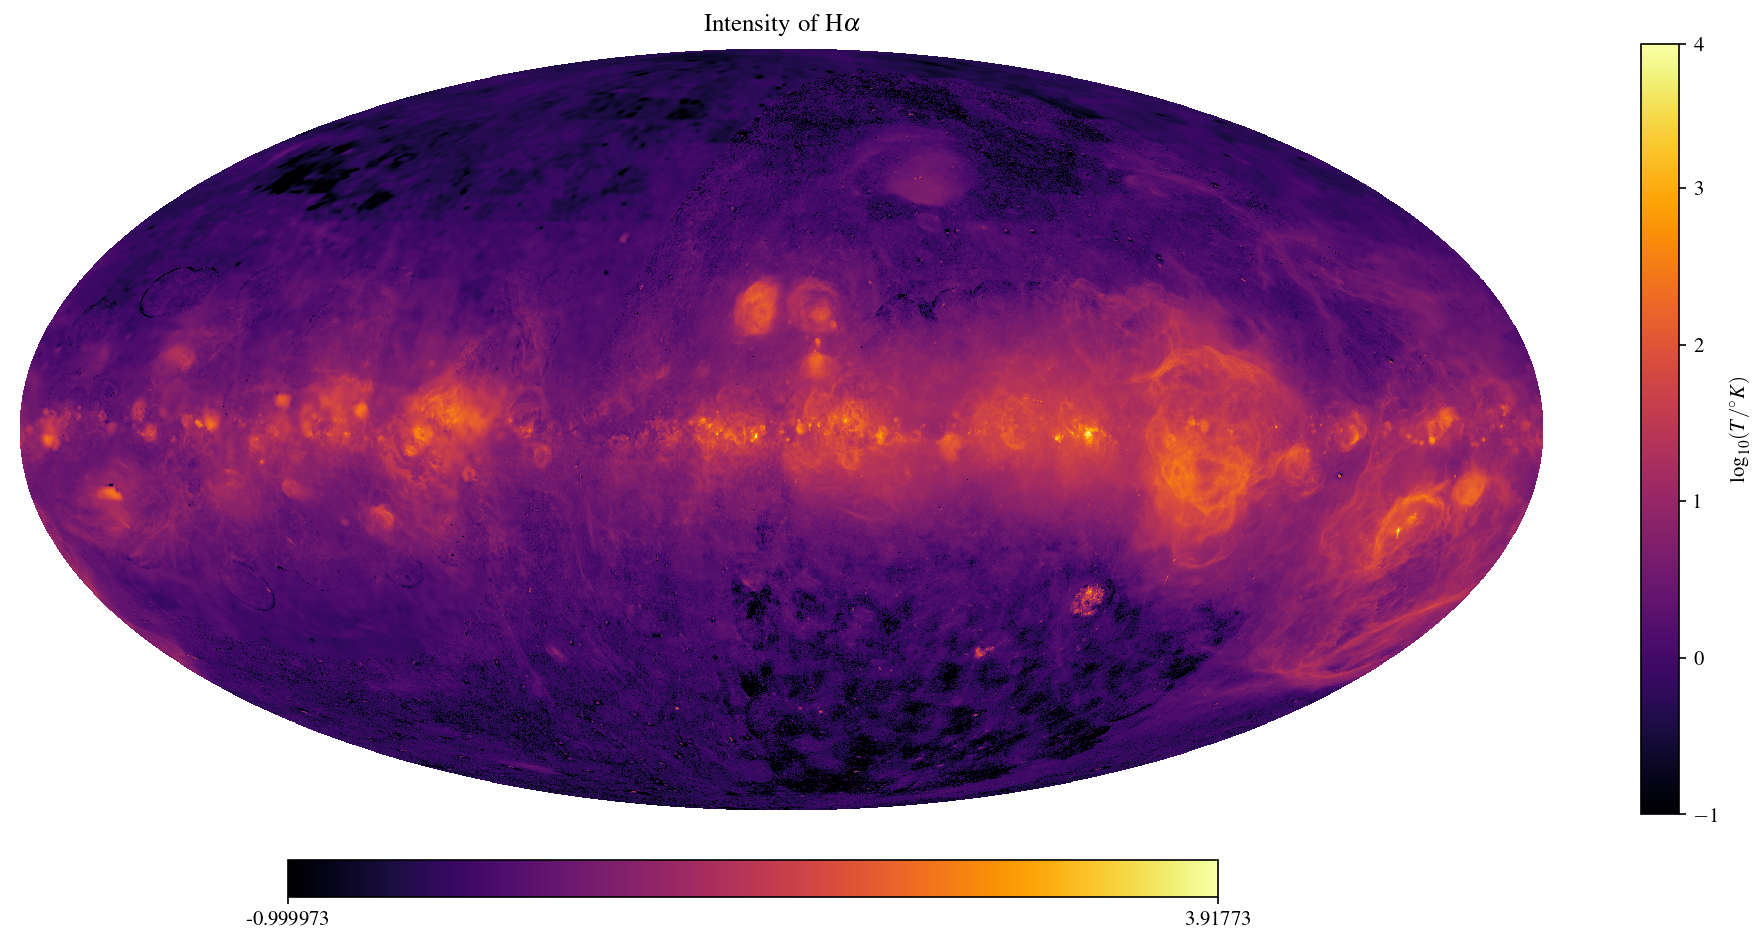

In [38]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(halpha_temps)
hp.mollview(map, xsize = 3000, nest = True, cmap = 'inferno', hold = True, title=r'Intensity of H$\alpha$')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

In [39]:

#conversion factor 

conv_fac_ha = 2 * np.pi**2 * (Meter**2 * Second * Joule)/(CentiMeter**2*Second); conv_fac

1.2320270115419999e+18

In [40]:
# Recovering actual temperature
halpha_temps_64*conv_fac_ha

array([6.7767202e+14, 6.4412940e+14, 5.7308064e+14, ..., 4.1698015e+14,
       5.8255306e+14, 4.4586733e+14], dtype=float32)

# Structure and Point Source Mask

In [41]:
source_mask = np.load(DataDir + 'source_mask.npy')
source_templ = np.load(DataDir + 'source_templ.npy')

In [42]:
source_mask[source_mask ==1] = np.nan

In [43]:
source_templ = source_templ/1000

In [44]:
#source_templ = hp.ud_grade(source_templ,4)

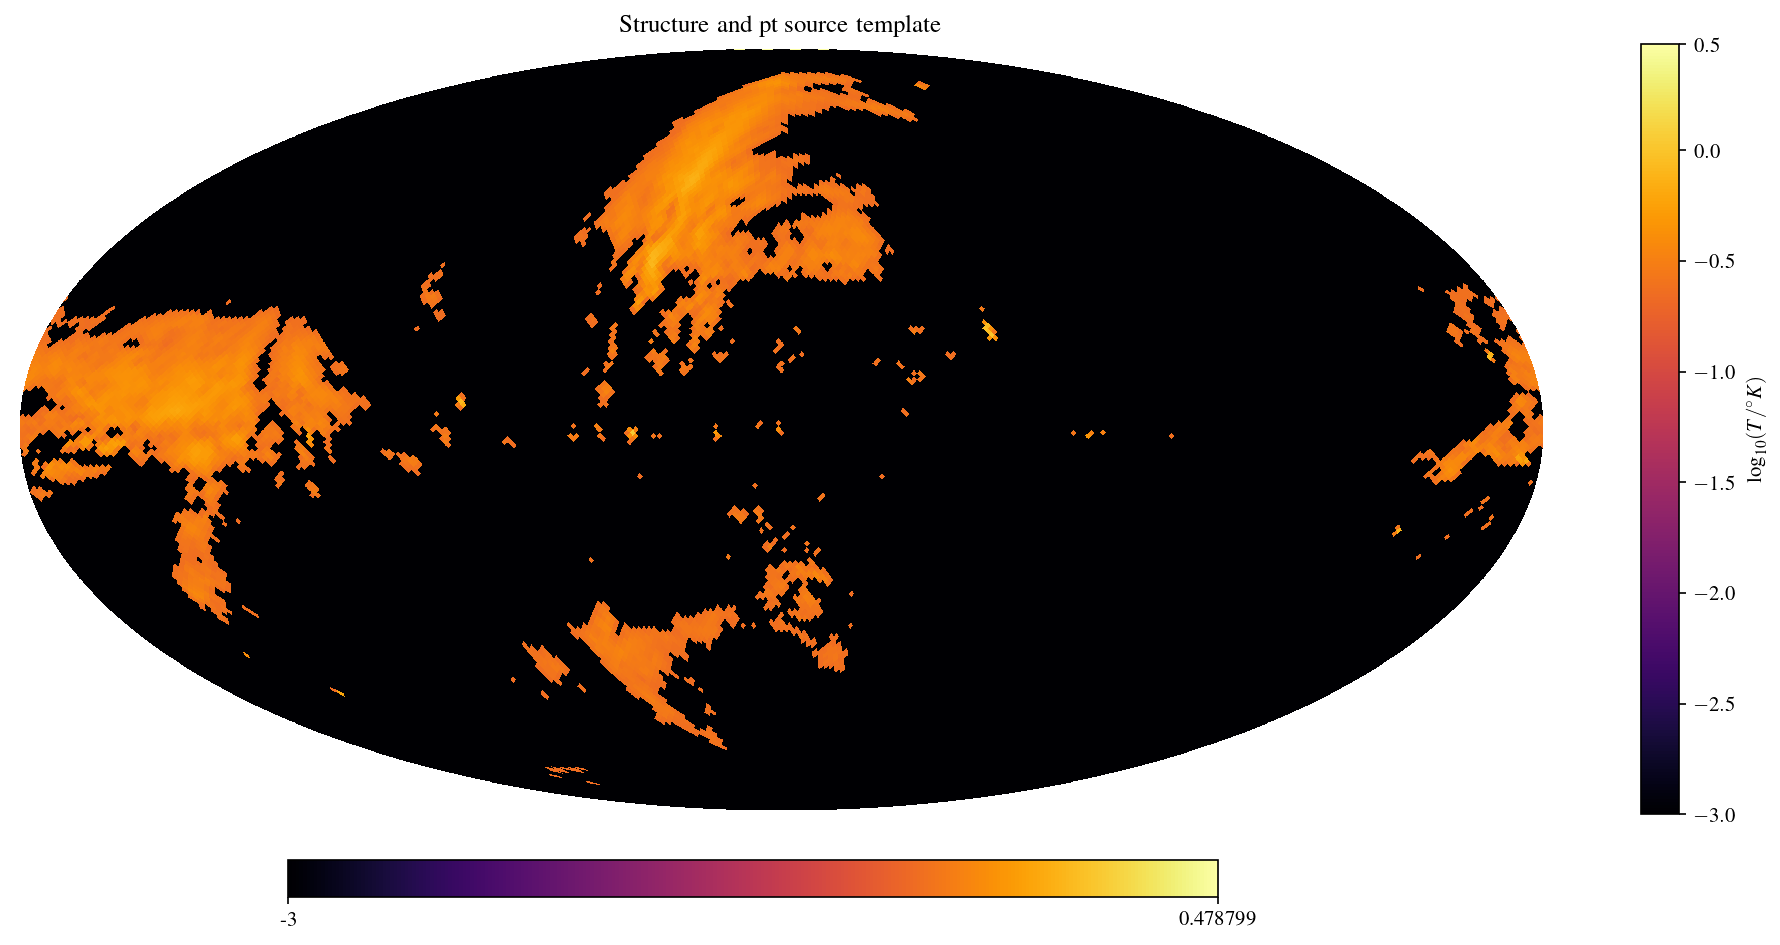

In [45]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(source_templ+1e-3)
hp.mollview(map, xsize = 3000, nest = False, cmap = 'inferno', hold = True, title=r'Structure and pt source template')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')


# Looking at Residuals

In [46]:
from scipy.optimize import leastsq

# raw data: Haslam 408 GHz map
data_map = radio_temps_64

#synchrotron map: GALPROP
synch_map = galprop_temps

#free-free map: Finkbeiner
free_free = halpha_temps_64

#error_map
error_map = fluc_map_64

#src_map = source_templ
source_mask = source_templ

#monopole map
monopole_map = np.ones(hp.nside2npix(64))

# Mask out low-b region
nside = 64
b_min = 10

data_map = remove_b(data_map, nside, b_min)
synch_map = remove_b(synch_map, nside, b_min)
free_free = remove_b(free_free, nside, b_min)
source_mask = remove_b(source_mask, nside, b_min)
error_map = remove_b(error_map, nside, b_min)
#monopole_map = remove_b(monopole_map, nside, b_min)

In [47]:
data_map_4 = hp.ud_grade(data_map, 4)
synch_map_4 = hp.ud_grade(synch_map, 4)
free_free_4 = hp.ud_grade(free_free, 4)
source_mask_4 = hp.ud_grade(source_mask, 4)
error_map_4 = hp.ud_grade(error_map, 4)
#monopole_map_4 = hp.ud_grade(monopole_map, 4)

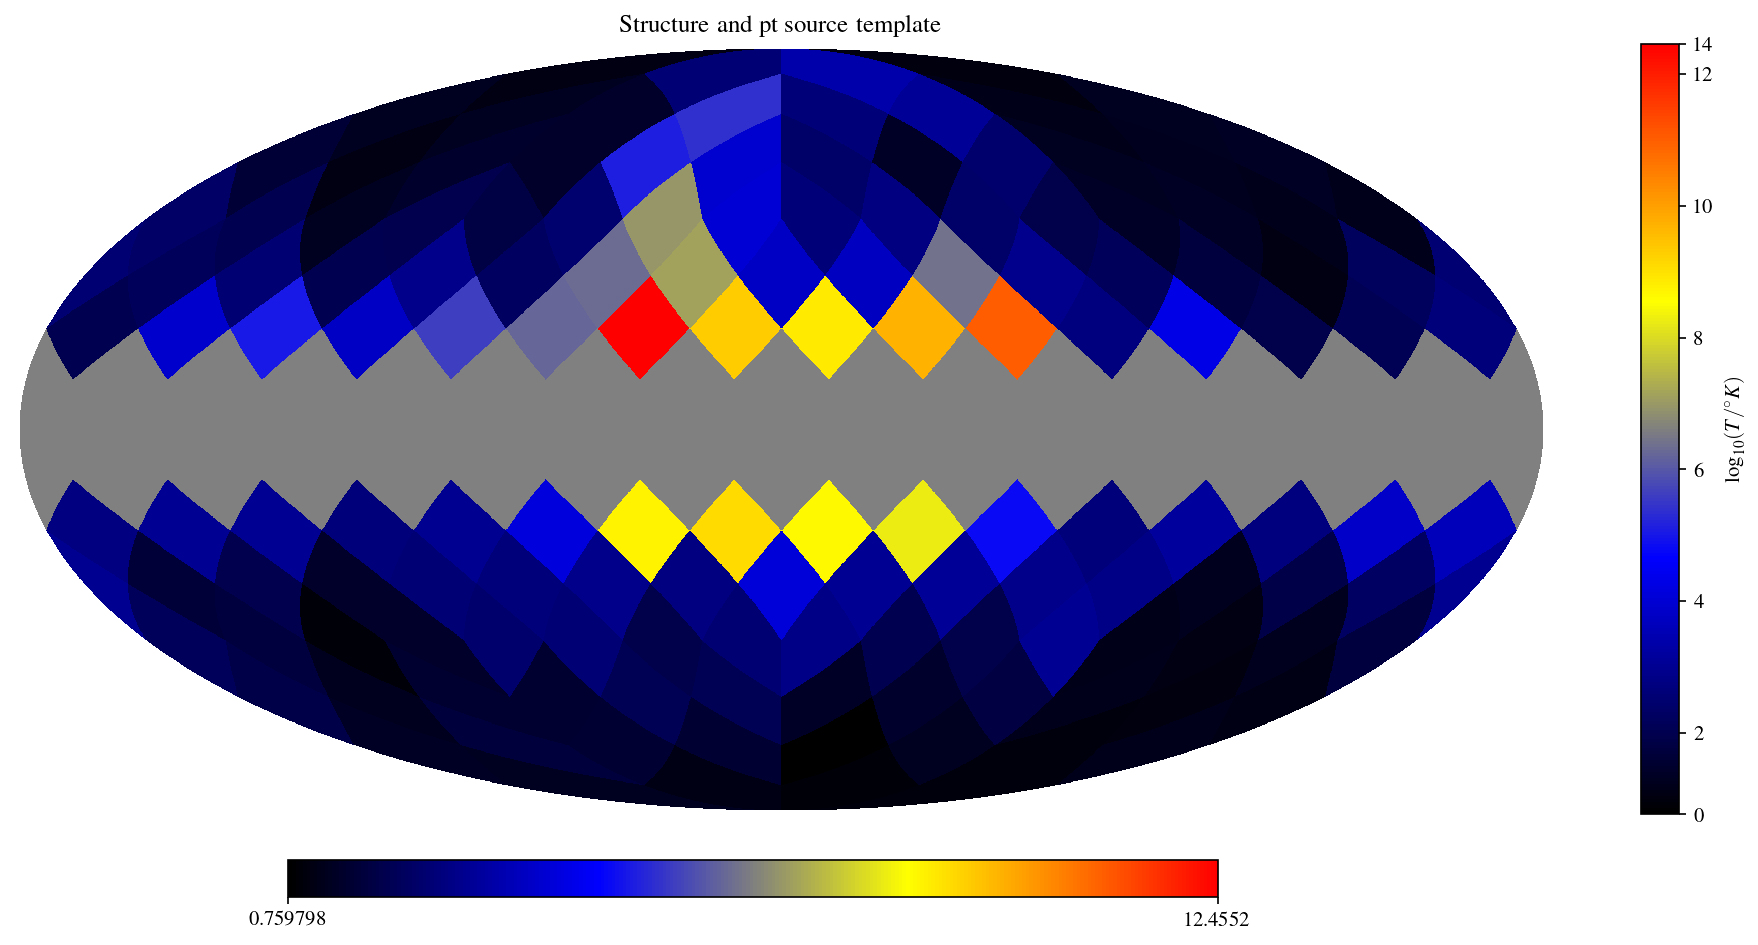

In [48]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = error_map_4
hp.mollview(map, xsize = 3000, nest = False, cmap = fng_cmap, hold = True, title=r'Structure and pt source template')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

In [49]:
#take care of NaNs
data_map_r = data_map_4[~np.isnan(data_map_4)]
synch_map_r = synch_map_4[~np.isnan(synch_map_4)]
free_free_r = free_free_4[~np.isnan(free_free_4)]
error_map_r = error_map_4[~np.isnan(error_map_4)]
source_mask_r = source_mask_4[~np.isnan(source_mask_4)]
#monopole_map_r = monopole_map_4[~np.isnan(monopole_map_4)]

In [50]:
def model(p, coeffs):
    c_mon = coeffs[0]
    c_syn = coeffs[1]
    c_ff = coeffs[2]
    c_src = coeffs[3]
    
    return c_mon + c_syn*synch_map_r[p] + c_ff*free_free_r[p] + c_src * source_mask_r[p]

def residuals(coeffs, obs, err, p):
    return (obs - model(p, coeffs))/err[p]

In [51]:
from scipy.optimize import least_squares
p = np.arange(len(data_map_r))
x0= [10, 1, 0, 0]
result = least_squares(residuals, x0, bounds = (0, 1000),args=(data_map_r, error_map_r, p))

In [52]:
c = result.x; c

array([1.23047172e+01, 2.17751720e-01, 7.82380653e-18, 6.23969016e-01])

In [53]:
residual_map = data_map_4 - (c[0] + c[1] * synch_map_4 + c[2] * free_free_4 + c[3] * source_mask_4)

In [54]:
residual_map = residual_map/data_map_4

In [55]:
residual_map = remove_b(residual_map, 4, b_min)

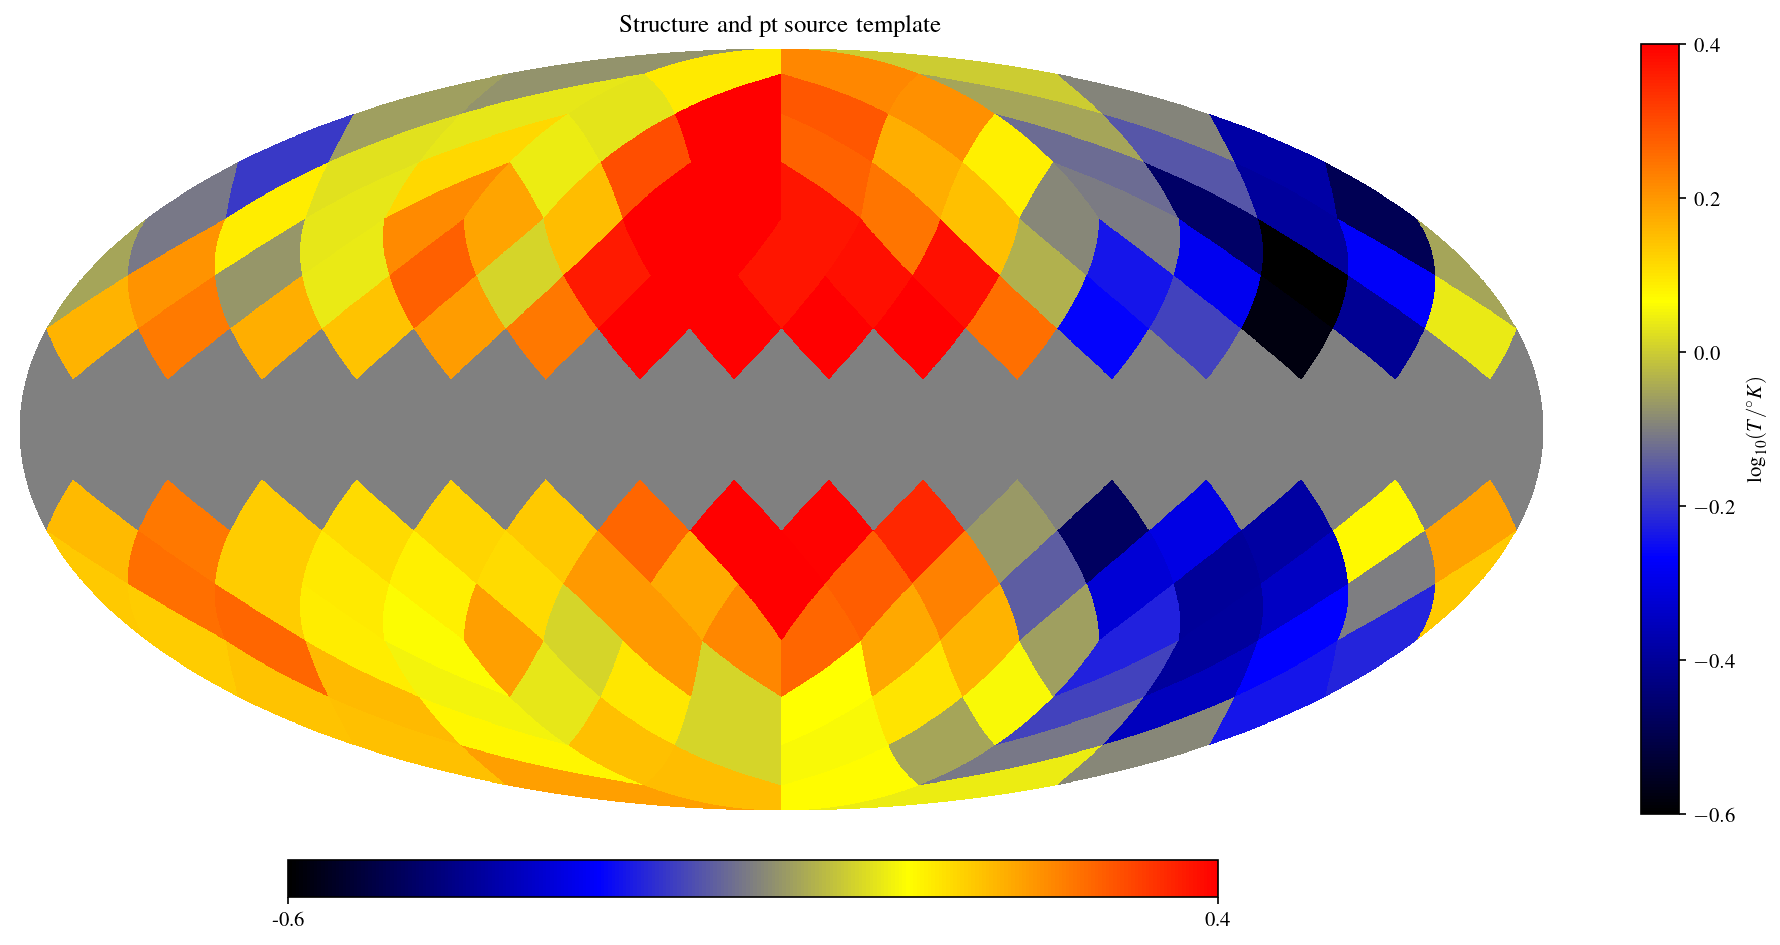

In [56]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = residual_map
hp.mollview(map, xsize = 3000, nest = False, min = -0.6, max = 0.4, cmap = fng_cmap,hold = True, title=r'Structure and pt source template')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

 # Iterative Masking Procedure

In [57]:
#data_map_4 = hp.ud_grade(data_map, 4)
#synch_map_4 = hp.ud_grade(synch_map, 4)
#free_free_4 = hp.ud_grade(free_free, 4)
#source_mask_4 = hp.ud_grade(source_mask, 4)
#error_map_4 = hp.ud_grade(error_map, 4)
#monopole_map_4 = hp.ud_grade(monopole_map, 4)

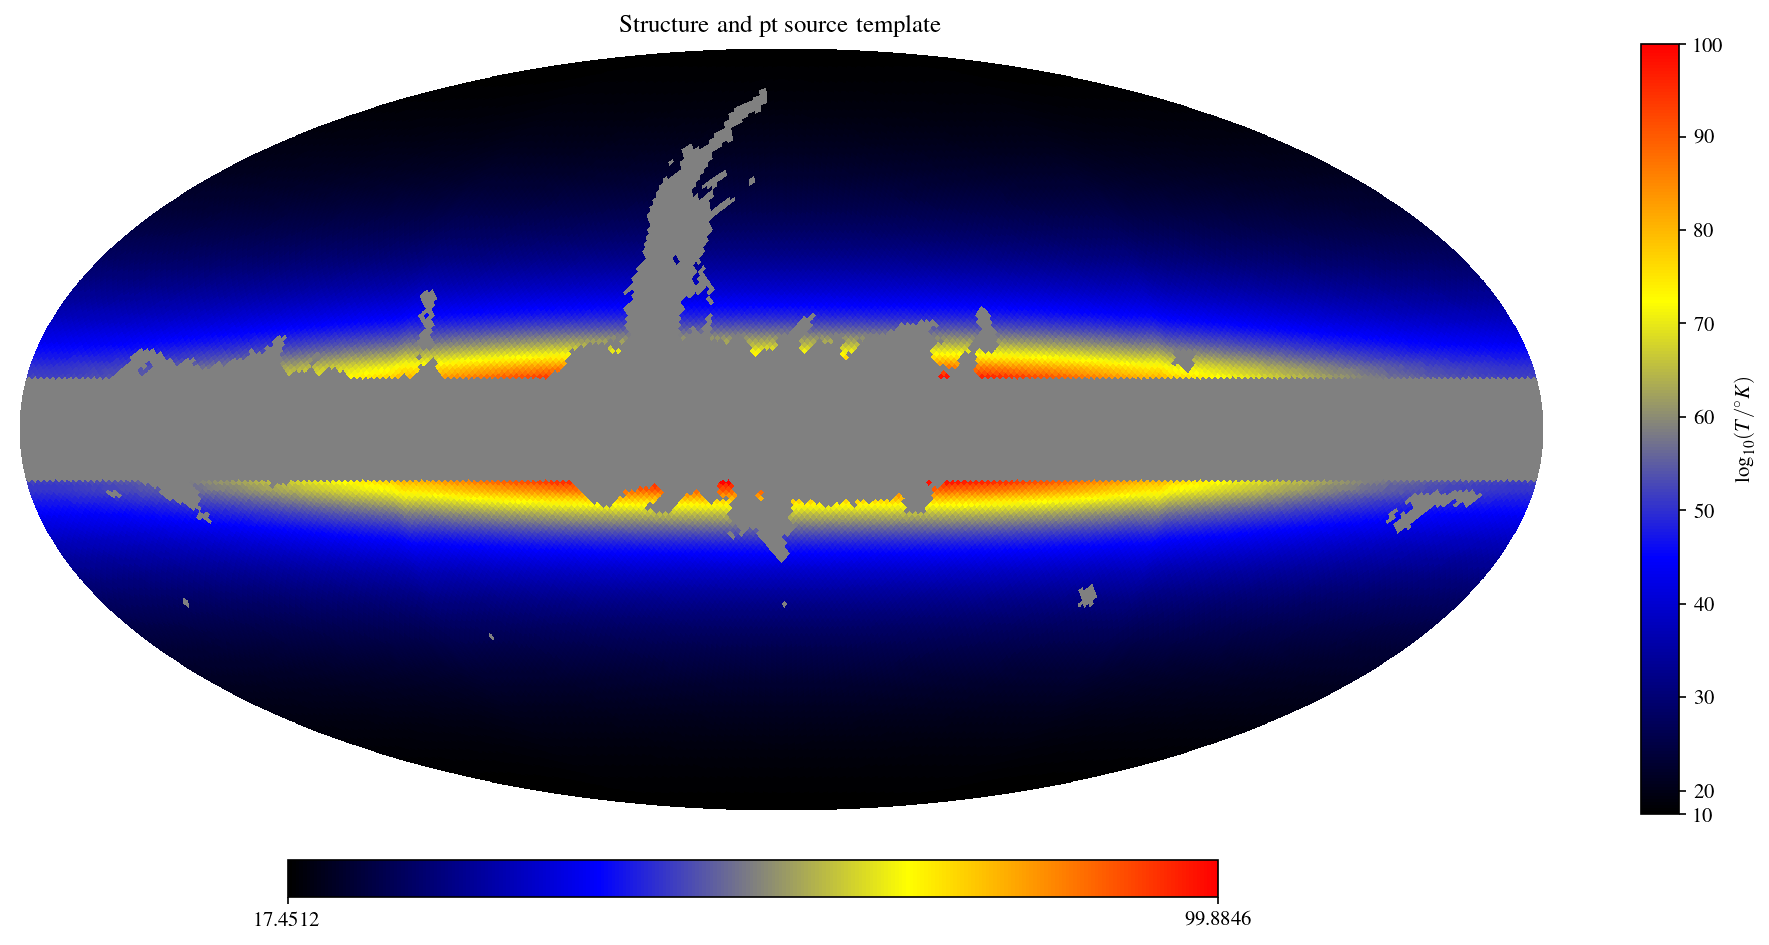

In [109]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = synch_map
hp.mollview(map, xsize = 3000, nest = False, cmap = fng_cmap, hold = True, title=r'Structure and pt source template')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

In [136]:

#monopole_map_r = monopole_map_4[~np.isnan(monopole_map_4)]

In [162]:
def model(p, coeffs):
    c_mon = coeffs[0]
    c_syn = coeffs[1]
    c_ff = coeffs[2]    
    
    return c_mon + c_syn*synch_map_r[p] + c_ff*free_free_r[p] 

def residuals(coeffs, obs, err, p):
    return (obs - model(p, coeffs))/err[p]

def fluct_map_residual_par(idx, skymap, nside, vectors, rms, calib):       
    if (~np.isnan(skymap[idx])):
        inds = hp.query_disc(nside, (vectors[0][idx], vectors[1][idx], vectors[2][idx]), radius = 50 * degree, inclusive = False)
        temps = skymap[inds]
        temps_r = temps[~np.isnan(temps)]
    
        t = np.mean(temps_r)
        #t = np.average(temps_r, weights = 1/(rms**2 + (calib * temps_r)**2))
        
        f = np.sqrt(np.var(temps_r) + rms**2 + (calib * skymap[idx])**2)
        return t, f
    else:
        return np.nan, np.nan

In [163]:
# raw data: Haslam 408 GHz map
data_map = radio_temps_64

#synchrotron map: GALPROP
synch_map = galprop_temps

#free-free map: Finkbeiner
free_free = halpha_temps_64

#error_map
error_map = fluc_map_64

#src_map = source_templ
source_mask = source_templ

#monopole map
monopole_map = np.ones(hp.nside2npix(64))

# Mask out low-b region
nside = 64
b_min = 10

data_map = remove_b(data_map, nside, b_min)
synch_map = remove_b(synch_map, nside, b_min)
free_free = remove_b(free_free, nside, b_min)
source_mask = remove_b(source_mask, nside, b_min)
error_map = remove_b(error_map, nside, b_min)
#monopole_map = remove_b(monopole_map, nside, b_min)

In [164]:
too_bright = 1
nsig = 5
num_itr = 0
fit_params = []

while(too_bright != 0):
    data_map_r = data_map[~np.isnan(data_map)]
    synch_map_r = synch_map[~np.isnan(synch_map)]
    free_free_r = free_free[~np.isnan(free_free)]
    error_map_r = error_map[~np.isnan(error_map)]
    source_mask_r = source_mask[~np.isnan(source_mask)]

    p = np.arange(len(data_map_r))
    x0= [0.01, 0, 0]
    result = least_squares(residuals, x0, bounds = (0, 1000),args=(data_map_r, error_map_r, p))

    c = result.x
    
    residual_map = data_map - (c[0] + c[1] * synch_map + c[2] * free_free)
    
    residual_map = remove_b(residual_map, 64, b_min)
    
    nside = hp.npix2nside(len(residual_map))
    pix_list = np.arange(len(residual_map))
    vec = hp.pix2vec(nside, pix_list)

    num_cores_used = 5

    mean_t, res_fl = zip(*Parallel(n_jobs=num_cores_used)(delayed(fluct_map_residual_par)(idx, residual_map, nside, vec, 1.2, 0.1)
                                                          for idx in pix_list))
    mean_t = np.asarray(mean_t); res_fl = np.asarray(res_fl)

    too_bright = len(residual_map[residual_map > mean_t + nsig * res_fl])
    if(too_bright == 0):
        print('Done!')
        print('Final fit params: ' + str(c))
    else:
        print('Removing ' + str(too_bright) + ' overly-bright source(s)...')
        print('Fit params: ' + str(c))

    data_map[residual_map > mean_t + nsig * res_fl] = np.nan
    synch_map[residual_map > mean_t + nsig * res_fl] = np.nan
    free_free[residual_map > mean_t + nsig * res_fl] = np.nan
    error_map[residual_map > mean_t + nsig * res_fl] = np.nan
    
    num_itr += 1
    fit_params = c


Removing 1 overly-bright source(s)...
Fit params: [1.24897097e+01 2.05602690e-01 1.29336862e-19]
Done!
Final fit params: [1.24898904e+01 2.05594565e-01 4.96652681e-20]


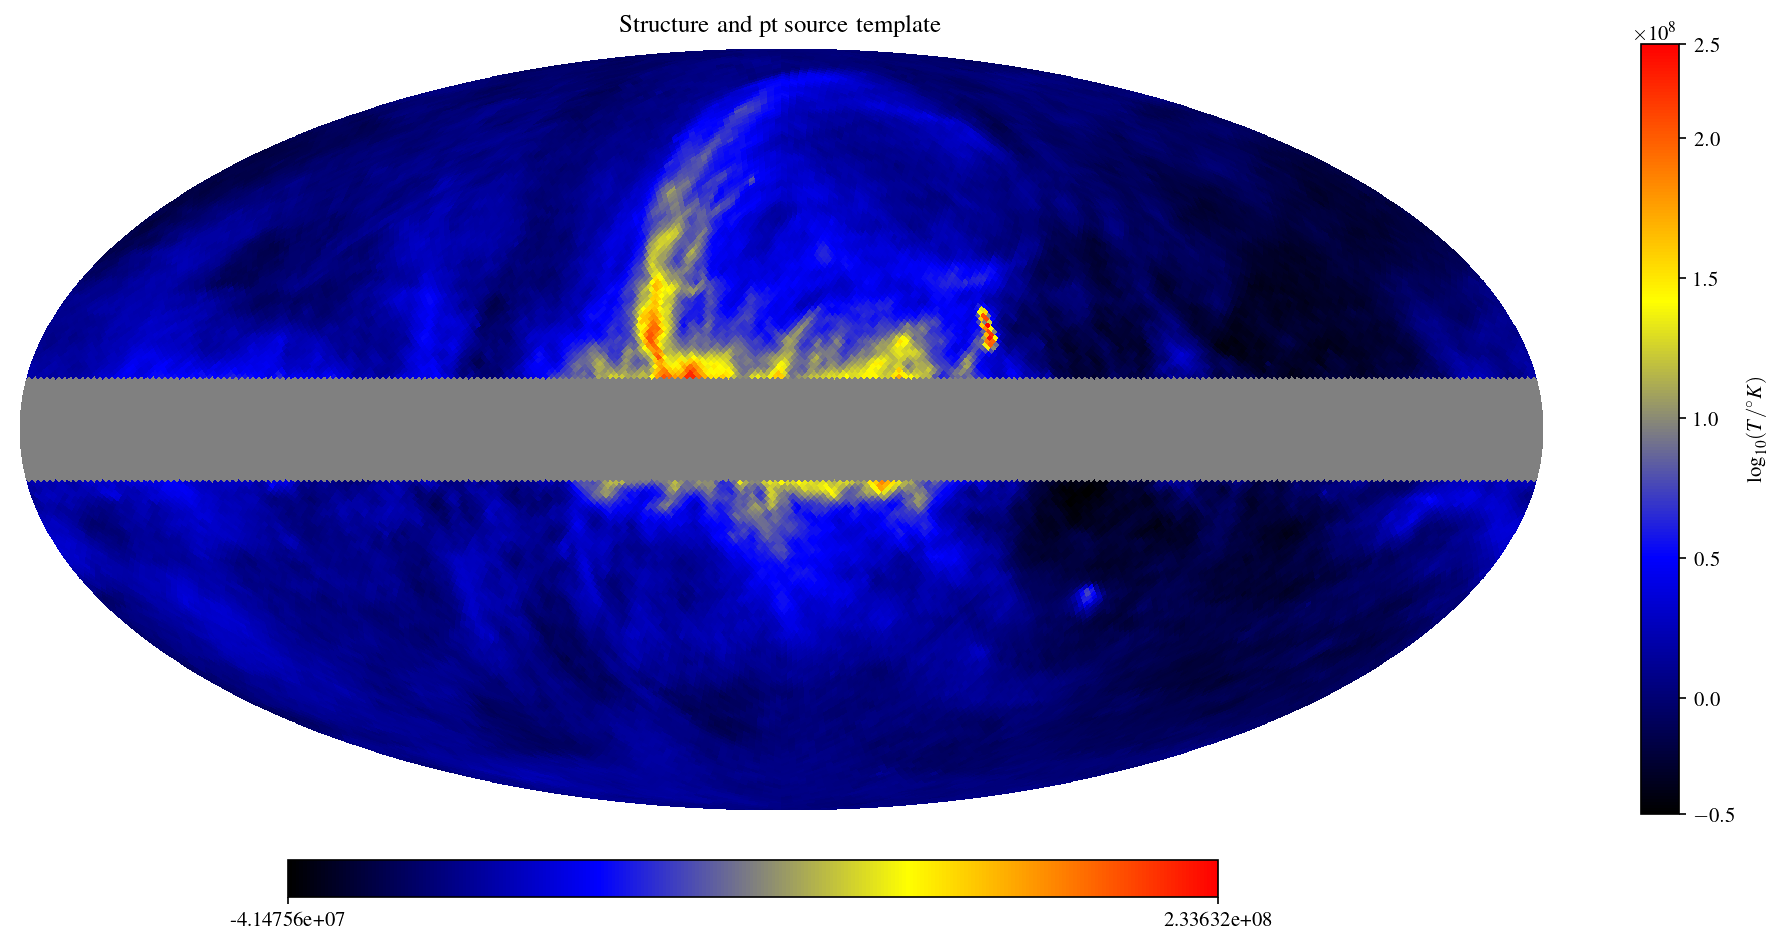

In [158]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = residual_map * (408 ** 2.5)
hp.mollview(map, xsize = 3000, nest = False, cmap = fng_cmap, hold = True, title=r'Structure and pt source template')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

In [148]:
degree

0.017453292519943295

In [149]:
np.pi/180

0.017453292519943295

# "Blind" monopole injection

In [ ]:
# Secret number, temperature of the isotropic excess we will try to measure
secret_number = 15

In [ ]:
nside = 64
freq = 408 #MHz
sky = pysm3.Sky(nside=64, preset_strings=['s1'])
emiss_map = sky.get_emission(freq * u.MHz)
emiss_temp_map = emiss_map[0].to(u.K_RJ).value + secret_number

In [ ]:
abs_b = np.abs(hp.pix2ang(nside, np.arange(len(emiss_temp_map)), nest = False, lonlat = True)[1])
abs_b = np.radians(abs_b)
csc_b_map = 1/np.sin(abs_b)

In [ ]:
from scipy.optimize import leastsq

#define the map to be treated as data (e.g., Haslam, PySM)

data_map = emiss_temp_map #PySM fake data + extragalactic monopole
#data_map = radio_temps_64 #Haslam data
#data_map = galprop_temp #GALPROP

#define the map to be used as a model (e.g., GALPROP, csc|b|, PySM)

model_map = galprop_temps #GALPROP temperatures
#model_map = emiss_map[0].to(u.K_RJ).value #PySM synch map (no bg)
#model_map = csc_b_map


src_map = source_templ

# Mask out low-b region
nside = 64
b_min = 10

data_map = remove_b(data_map, nside, b_min)
model_map = remove_b(model_map, nside, b_min)
src_map = remove_b(src_map, nside, b_min)

In [ ]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(data_map)
hp.mollview(map, xsize = 3000, nest = False, cmap = 'inferno', hold = True, title=r'Fake Data Map at $\nu=$ ' + str(freq) + ' MHz')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')


In [ ]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(model_map)
hp.mollview(map, xsize = 3000, nest = False, cmap = 'inferno', hold = True, title=r'Model map at $\nu=$ ' + str(freq) + ' MHz')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

In [ ]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(src_map+1e-3)
hp.mollview(map, xsize = 3000, nest = False, cmap = 'inferno', hold = True, title=r'Model map at $\nu=$ ' + str(freq) + ' MHz')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

In [ ]:
#take care of NaNs
data_map = data_map[~np.isnan(data_map)]
model_map = model_map[~np.isnan(model_map)]
src_map = src_map[~np.isnan(src_map)]

In [ ]:
def model(p, coeffs):
    return coeffs[0]*model_map[p] + coeffs[1]*src_map[p] + coeffs[2]

def residuals(coeffs, obs, p):
    return (obs - model(p, coeffs))

In [ ]:
p = np.arange(len(data_map))
x0= [1, 0,3]
x, flag = leastsq(residuals, x0, args=(data_map, p))

In [ ]:
print('Coefficients: ' + str(x[0]) + ', ' + str(x[1])); print('Secret Number: ' + str(x[2]))

In [ ]:
x[1]*(408**2.5)

In [ ]:
nu_map = x[0]*model_map + x[1]*src_map + x[2]

In [ ]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(nu_map)
hp.mollview(map, xsize = 3000, nest = False, cmap = 'inferno', hold = True, title=r'Model map at $\nu=$ ' + str(freq) + ' MHz')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

# Attempts at making a template

In [ ]:
# raw data: Haslam 408 GHz map
raw_data = radio_temps_64

#synchrotron map: GALPROP
synch_map = galprop_temps

#free-free map: PySM
'''
freq = 408 #MHz
sky = pysm3.Sky(nside=64, preset_strings=['f1'])
emiss_map = sky.get_emission(freq * u.MHz)
#free_free = emiss_map[0].to(u.K_RJ).value
'''
free_free = halpha_temps_64
src_map = source_templ
# Mask out low-b region
nside = 64
b_min = 10

raw_data = remove_b(raw_data, nside, b_min)
synch_map = remove_b(synch_map, nside, b_min)
free_free = remove_b(free_free, nside, b_min)

In [ ]:
raw_data_4 = hp.ud_grade(raw_data, 4)

In [ ]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(raw_data_4)
hp.mollview(map, xsize = 3000, nest = False, cmap = 'inferno', hold = True, title=r'Raw data at $\nu=$ ' + str(freq) + ' MHz')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')


In [ ]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(synch_map)
hp.mollview(map, xsize = 3000, nest = False, cmap = 'inferno', hold = True, title=r'Synchrotron Model map at $\nu=$ ' + str(freq) + ' MHz')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

In [ ]:
free_free_4 = hp.ud_grade(free_free, 4)

In [ ]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(free_free_4)
hp.mollview(map, xsize = 3000, nest = False, cmap = 'inferno', hold = True, title=r'Free-Free map at $\nu=$ ' + str(freq) + ' MHz')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

In [ ]:
#take care of NaNs
raw_data_r = raw_data[~np.isnan(raw_data)]
synch_map_r = synch_map[~np.isnan(synch_map)]
free_free_r = free_free[~np.isnan(free_free)]
src_map_r = src_map[~np.isnan(src_map)]

In [ ]:
def model(p, coeffs):
    c_mon = coeffs[0]
    c_syn = coeffs[1]
    c_ff = coeffs[2]
    c_PI = coeffs[3]
    
    return c_mon + c_syn*synch_map_r[p] + c_ff*free_free_r[p] + c_PI*src_map_r[p]

def residuals(coeffs, obs, p):
    return obs - model(p, coeffs)

In [ ]:
from scipy.optimize import least_squares
p = np.arange(len(raw_data_r))
x0= [1, 1, 0, 0]
result = least_squares(residuals, x0, bounds = (0, 15),args=(raw_data_r, p))

In [ ]:
x = result.x ; x

In [ ]:
template = np.asarray(raw_data - x[1]*synch_map - x[2]*free_free - x[3]*src_map)
template = template - x[0]

In [ ]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = template
hp.mollview(map, xsize = 3000, min = 0, nest = False, cmap = 'inferno', hold = True, title=r'Point source and structure template at $\nu=$ ' + str(freq) + ' MHz')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

# Convolve With Errors

In [ ]:
def convolve(skymap, error_map):
    return np.asarray([np.random.normal(value, error_map*value) for value in skymap])

In [ ]:
cnv = convolve(nu_map, 0.05)

In [ ]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log(cnv)
hp.mollview(map, xsize = 3000, nest = False, cmap = 'inferno', hold = True, title=r'Point source and structure template at $\nu=$ ' + str(freq) + ' MHz')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')